# Credit Card Fraud Detection

## About Dataset

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [2]:
import math
import pandas as pd
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from tensorflow.python.framework import ops


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Data Preprocessing

In [3]:
dataset = pd.read_csv("creditcard.csv.zip", header = 0)

In [4]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
print("Percent of total transactions that are fraudulent")
print(dataset["Class"].mean()*100)

Percent of total transactions that are fraudulent
0.1727485630620034


 Fraudulent transactions represent only ~0.17% of total transactions. This means that we are aiming to predict anomalous events.

In [7]:
print("Losses due to fraud:")
print("Total amount lost to fraud")
print(dataset.Amount[dataset.Class == 1].sum())
print("Mean amount per fraudulent transaction")
print(dataset.Amount[dataset.Class == 1].mean())
print("Compare to normal transactions:")
print("Total amount from normal transactions")
print(dataset.Amount[dataset.Class == 0].sum())
print("Mean amount per normal transactions")
print(dataset.Amount[dataset.Class == 0].mean())

Losses due to fraud:
Total amount lost to fraud
60127.97
Mean amount per fraudulent transaction
122.21132113821139
Compare to normal transactions:
Total amount from normal transactions
25102462.04
Mean amount per normal transactions
88.29102242231328


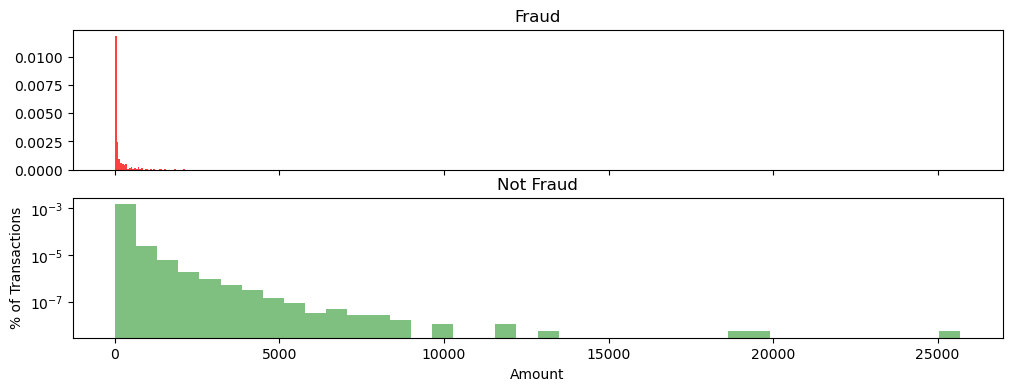

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 4))

bins = 40
ax1.hist(dataset.Amount[dataset.Class == 1], bins=bins, density=True, alpha=0.75, color='red')
ax1.set_title('Fraud')

ax2.hist(dataset.Amount[dataset.Class == 0], bins=bins, density=True, alpha=0.5, color='green')
ax2.set_title('Not Fraud')

plt.xlabel('Amount')
plt.ylabel('% of Transactions')
plt.yscale('log')
plt.show()

It is interesting to see that while fraudulent transactions make up a small portion of the data set, they have a higher average amount per transaction. It may be useful to try a model with Amount as a feature.

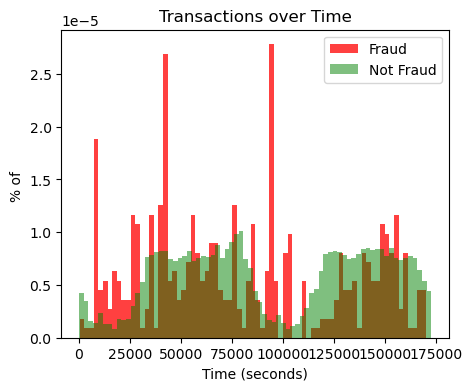

In [9]:
bins = 75
plt.hist(dataset.Time[dataset.Class == 1], bins = bins, density= True, alpha = 0.75, label = 'Fraud', color = 'red')
plt.hist(dataset.Time[dataset.Class == 0], bins = bins, density= True, alpha = 0.5, label = 'Not Fraud', color = 'green')
plt.legend(loc='upper right')
plt.xlabel('Time (seconds)')
plt.ylabel('% of ')
plt.title('Transactions over Time')
plt.show()

This histogram shows the percentage of transactions made over the time period. We see that more fraudulent activity typically happens when there is downtime in overall transactions. If we assume that the data is collected from Day 0 12:01 AM to Day 2 11:59 PM, since it is described as being collected over "two days", we see that fraudulent activity is occuring in the very early AM. I am reluctant to use Time as a feature here in our predictive model because there is only two days of data. If there was a month or so of data, this would definitely be useful as a feature if we see a similar pattern over a longer time period.

Let's take a look at the V1,...,V28 features.

In [10]:
Vfeatures = dataset.iloc[:,1:29].columns
print(Vfeatures)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')


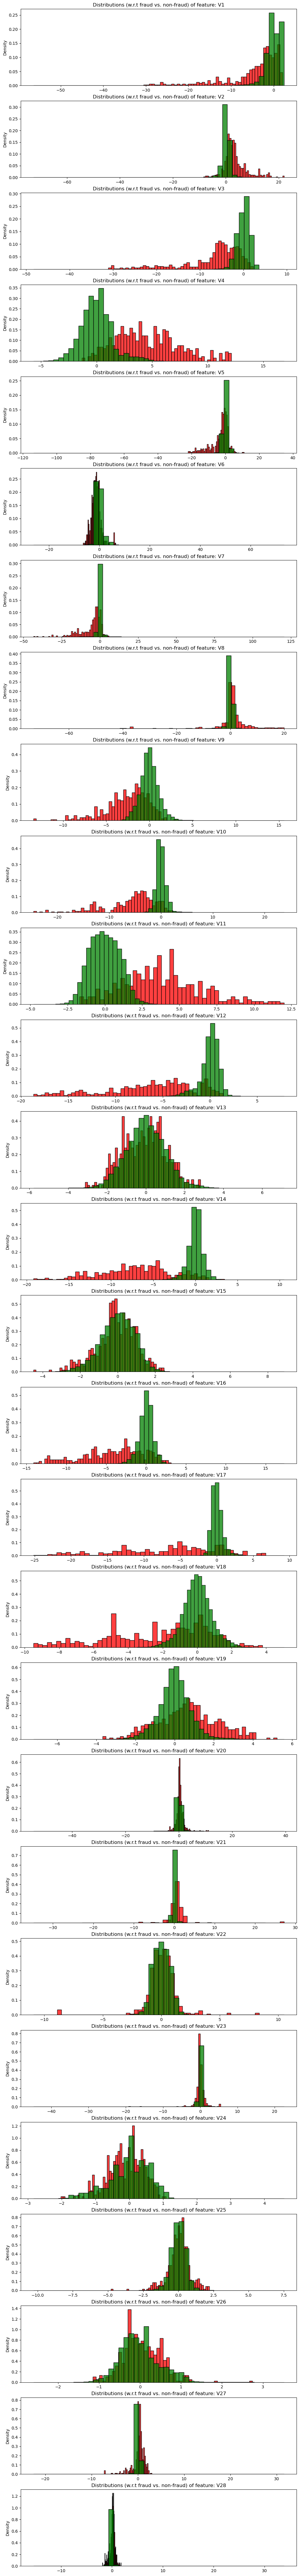

In [11]:
import matplotlib.gridspec as gridspec
import seaborn as sns

bins = 50
plt.figure(figsize=(12, 28*4))
gs = gridspec.GridSpec(28, 1)

for i, V in enumerate(dataset[Vfeatures]):
    ax = plt.subplot(gs[i])
    sns.histplot(dataset[V][dataset.Class == 1], bins=bins , color='red', stat='density')
    sns.histplot(dataset[V][dataset.Class == 0], bins=bins , color='green', stat='density')
    ax.set_xlabel('')
    ax.set_title('Distributions (w.r.t fraud vs. non-fraud) of feature: ' + str(V))

plt.show()

This shows the distribution differences of the features when comparing fraudulent transactions to normal transactions.

# Train-Test Split

In [12]:
# Import library
from sklearn.model_selection import train_test_split

In [13]:
# Putting feature variables into X
X = dataset.drop(['Class'], axis=1)

In [14]:
# Putting target variable to y
y = dataset['Class']

In [15]:
# Splitting data into train and test set 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

## Feature Scaling

We need to scale only the Amount column as all other columns are already scaled by the PCA transformation.

In [16]:
# Standardization method
from sklearn.preprocessing import StandardScaler

# Instantiate the Scaler
scaler = StandardScaler()

# Fit the data into scaler and transform
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])



In [17]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
201788,134039.0,2.023734,-0.429219,-0.691061,-0.201461,-0.162486,0.283718,-0.674694,0.192230,1.124319,...,-0.171390,-0.195207,-0.477813,0.340513,0.059174,-0.431015,-0.297028,-0.000063,-0.046947,-0.345273
179369,124044.0,-0.145286,0.736735,0.543226,0.892662,0.350846,0.089253,0.626708,-0.049137,-0.732566,...,0.206709,-0.124288,-0.263560,-0.110568,-0.434224,-0.509076,0.719784,-0.006357,0.146053,-0.206439
73138,54997.0,-3.015846,-1.920606,1.229574,0.721577,1.089918,-0.195727,-0.462586,0.919341,-0.612193,...,0.842838,0.274911,-0.319550,0.212891,-0.268792,0.241190,0.318445,-0.100726,-0.365257,0.358043
208679,137226.0,1.851980,-1.007445,-1.499762,-0.220770,-0.568376,-1.232633,0.248573,-0.539483,-0.813368,...,-0.196551,-0.406722,-0.899081,0.137370,0.075894,-0.244027,0.455618,-0.094066,-0.031488,0.362400
206534,136246.0,2.237844,-0.551513,-1.426515,-0.924369,-0.401734,-1.438232,-0.119942,-0.449263,-0.717258,...,-0.045417,0.050447,0.125601,0.215531,-0.080485,-0.063975,-0.307176,-0.042838,-0.063872,-0.316109


Scale the test set

In [18]:
# Transform the test set
X_test['Amount'] = scaler.transform(X_test[['Amount']])
X_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
49089,43906.0,1.229452,-0.235478,-0.627166,0.419877,1.797014,4.069574,-0.896223,1.036103,0.745991,...,-0.057922,-0.170060,-0.288750,-0.130270,1.025935,0.847990,-0.271476,0.060052,0.018104,-0.340485
154704,102638.0,2.016893,-0.088751,-2.989257,-0.142575,2.675427,3.332289,-0.652336,0.752811,1.962566,...,-0.147619,-0.184153,-0.089661,0.087188,0.570679,0.101899,0.620842,-0.048958,-0.042831,-0.320859
67247,52429.0,0.535093,-1.469185,0.868279,0.385462,-1.439135,0.368118,-0.499370,0.303698,1.042073,...,0.437685,0.028010,-0.384708,-0.128376,0.286638,-0.136700,0.913904,-0.083364,0.052485,0.853442
251657,155444.0,2.128486,-0.117215,-1.513910,0.166456,0.359070,-0.540072,0.116023,-0.216140,0.680314,...,-0.227278,-0.357993,-0.905085,0.223474,-1.075605,-0.188519,0.267672,-0.071733,-0.072238,-0.344410
201903,134084.0,0.558593,1.587908,-2.368767,5.124413,2.171788,-0.500419,1.059829,-0.254233,-1.959060,...,0.249457,-0.035049,0.271455,0.381606,0.332001,-0.334757,0.448890,0.168585,0.004955,-0.229480


# Models

In [19]:
# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

In [20]:
results = pd.DataFrame(columns=['Model Name', 'Accuracy', 'F1-score', 'ROC'])

In [21]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

# Logistic regression

In [22]:
# Importing scikit logistic regression module
from sklearn.linear_model import LogisticRegression

In [23]:
# Instantiate the model with best C
logistic = LogisticRegression(C=0.01)

In [24]:
# Fit the model on the train set
logistic_model = logistic.fit(X_train, y_train)

C:\Users\haumt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# Prepare results function
def display_test_results(model_name, model):
    
    # Prediction on the test set
    y_test_pred = model.predict(X_test)
    
    # Confusion matrix
    print("------------------ Confusion Matrix --------------------")
    c_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    print(c_matrix)
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()
    

    # classification_report
    print("------------------ classification_report --------------------")
    print(classification_report(y_test, y_test_pred))
    
    print("------------------ More Specific classification_report --------------------")
    TP = c_matrix[1,1] # true positive 
    TN = c_matrix[0,0] # true negatives
    FP = c_matrix[0,1] # false positives
    FN = c_matrix[1,0] # false negatives
    
        # Accuracy
    print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

    # Sensitivity
    print("Sensitivity:-",TP / float(TP+FN))

    # Specificity
    print("Specificity:-", TN / float(TN+FP))

    # F1 score
    print("F1-Score:-", f1_score(y_test, y_test_pred))

    # Predicted probability
    y_test_pred_proba = model.predict_proba(X_test)[:,1]

    # roc_auc
    print("------------------ ROC --------------------")
    roc_auc = metrics.roc_auc_score(y_test, y_test_pred_proba)

    # Plot the ROC curve
    draw_roc(y_test, y_test_pred_proba)

    # add all metrics score in final result store
    results.loc[len(results)] = [model_name, metrics.accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred), roc_auc]

    return None

## Prediction results

------------------ Confusion Matrix --------------------
[[56840    26]
 [   34    62]]


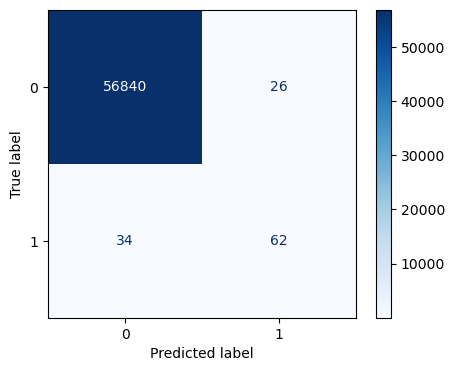

------------------ classification_report --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.70      0.65      0.67        96

    accuracy                           1.00     56962
   macro avg       0.85      0.82      0.84     56962
weighted avg       1.00      1.00      1.00     56962

------------------ More Specific classification_report --------------------
Accuracy:- 0.9989466661985184
Sensitivity:- 0.6458333333333334
Specificity:- 0.9995427847923188
F1-Score:- 0.6739130434782609
------------------ ROC --------------------


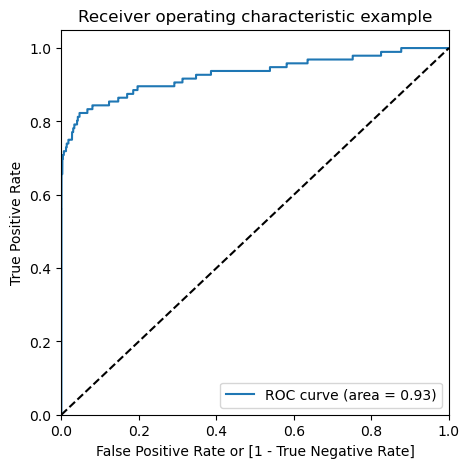

In [26]:
display_test_results("Logistic Regression", logistic_model)

We can see that we have very good ROC on the test set 0.98, which is almost close to 1.

## Decision Tree

In [28]:
# Importing decision tree classifier
from sklearn.tree import DecisionTreeClassifier

In [29]:
# Model with optimal hyperparameters
decision_tree_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=100,
                                  min_samples_split=100)

decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=100,
                       random_state=100)

Prediction results

------------------ Confusion Matrix --------------------
[[56836    30]
 [   40    56]]


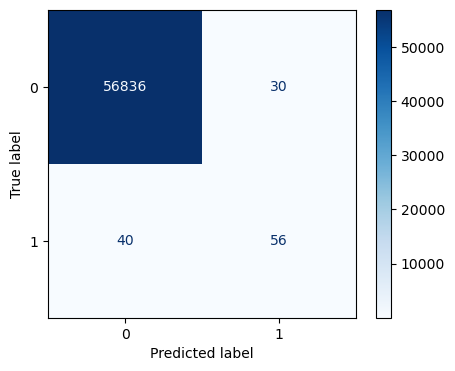

------------------ classification_report --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.65      0.58      0.62        96

    accuracy                           1.00     56962
   macro avg       0.83      0.79      0.81     56962
weighted avg       1.00      1.00      1.00     56962

------------------ More Specific classification_report --------------------
Accuracy:- 0.9987711105649381
Sensitivity:- 0.5833333333333334
Specificity:- 0.9994724439911371
F1-Score:- 0.6153846153846155
------------------ ROC --------------------


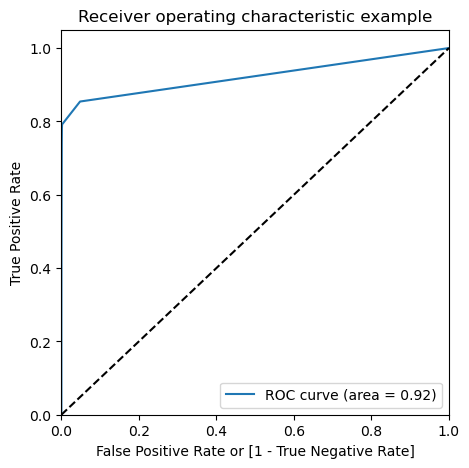

In [30]:
display_test_results("Decision Tree", decision_tree_model)

## Random forest

In [31]:
# Importing random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [32]:
random_forest_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             max_features=10,
                             n_estimators=100)

In [33]:
# Fit the model
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=10, min_samples_leaf=50,
                       min_samples_split=50)

------------------ Confusion Matrix --------------------
[[56843    23]
 [   35    61]]


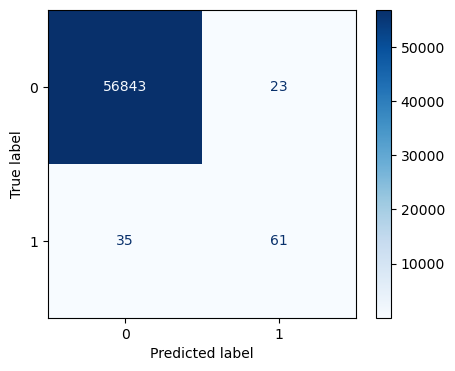

------------------ classification_report --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.73      0.64      0.68        96

    accuracy                           1.00     56962
   macro avg       0.86      0.82      0.84     56962
weighted avg       1.00      1.00      1.00     56962

------------------ More Specific classification_report --------------------
Accuracy:- 0.9989817773252344
Sensitivity:- 0.6354166666666666
Specificity:- 0.9995955403932051
F1-Score:- 0.6777777777777777
------------------ ROC --------------------


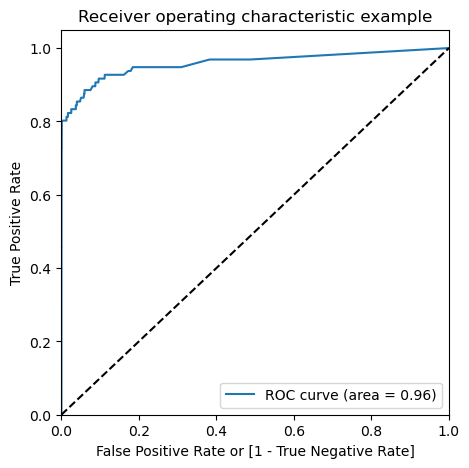

In [34]:
display_test_results("Random Forest", random_forest_model)

# Summary

In [35]:
results.sort_values(by="ROC", ascending=False)

,Model Name,Accuracy,F1-score,ROC
2,Random Forest,0.998982,0.677778,0.958784
0,Logistic Regression,0.998947,0.673913,0.928772
1,Decision Tree,0.998771,0.615385,0.921750
